In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.feature_column as fc 
import tensorflow.debugging as tfdbg
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/train.flat.csv", dtype={'fullVisitorId': 'str', 'visitId': 'str'})
df_t = pd.read_csv("data/test.flat.csv", dtype={'fullVisitorId': 'str', 'visitId': 'str'})
for col in df.columns:
#     print(col, df[col].fillna('').nunique())
    if df[col].fillna('').nunique() == 1:
        print("column skipped (cardinality = 1):", col)
        df = df.drop(col, axis=1)

column skipped (cardinality = 1): device.mobileDeviceInfo
column skipped (cardinality = 1): device.browserVersion
column skipped (cardinality = 1): totals.visits
column skipped (cardinality = 1): geoNetwork.networkLocation
column skipped (cardinality = 1): device.screenResolution
column skipped (cardinality = 1): geoNetwork.longitude
column skipped (cardinality = 1): geoNetwork.latitude
column skipped (cardinality = 1): device.flashVersion
column skipped (cardinality = 1): device.language
column skipped (cardinality = 1): trafficSource.adwordsClickInfo.criteriaParameters
column skipped (cardinality = 1): device.screenColors
column skipped (cardinality = 1): device.mobileDeviceModel
column skipped (cardinality = 1): socialEngagementType
column skipped (cardinality = 1): device.operatingSystemVersion
column skipped (cardinality = 1): device.mobileInputSelector
column skipped (cardinality = 1): device.mobileDeviceBranding
column skipped (cardinality = 1): geoNetwork.cityId
column skipped 

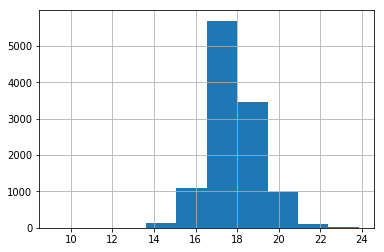

In [225]:
(np.log(df['totals.transactionRevenue'].dropna() +1)).hist()

In [4]:
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].fillna(0)

In [5]:
sdf = pd.DataFrame()
sdf_t = pd.DataFrame()
features = []

# boolean
for col in ['trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd', 'device.isMobile', 'totals.newVisits']:
    sdf[col] = df[col].apply(lambda x: 2 if np.isnan(x) else int(x))
    sdf_t[col] = df_t[col].apply(lambda x: 2 if np.isnan(x) else int(x))
    features.append(fc.indicator_column(fc.categorical_column_with_vocabulary_list(col, (0,1,2))))
        
# numeric
for col in ['visitNumber', 'visitStartTime', 'date', 'totals.hits', 'totals.pageviews']:
    minv = df[col].min()
    maxv = df[col].max()
    sdf[col] = df[col].apply(lambda x: (x-minv)/maxv).fillna(0)
    sdf_t[col] = df_t[col].apply(lambda x: (x-minv)/maxv).fillna(0)
    features.append(fc.numeric_column(col))

    
from sklearn.preprocessing import LabelEncoder
    
# string
for col in [
    'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.page',
    'channelGrouping',
    'geoNetwork.region',
    'geoNetwork.country',
    'geoNetwork.metro',
    'trafficSource.campaign',
    'totals.bounces',
    #'trafficSource.referralPath',
    'device.deviceCategory',
    'device.browser',
    'trafficSource.adContent',
    'trafficSource.medium',
    'geoNetwork.city',
    'trafficSource.source',
    'trafficSource.adwordsClickInfo.slot',
    'fullVisitorId',
    'geoNetwork.subContinent',
    'device.operatingSystem',
    #'geoNetwork.networkDomain',
    'trafficSource.adwordsClickInfo.gclId',
#     'trafficSource.campaignCode', // not exist in test
    'trafficSource.keyword',
    'geoNetwork.continent']:
    le = LabelEncoder()
    le.fit(pd.concat([df[col].astype(str).fillna(''), df_t[col].astype(str).fillna('')]))
    sdf[col] = le.transform(df[col].astype(str).fillna(''))
    sdf_t[col] = le.transform(df_t[col].astype(str).fillna(''))

In [6]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

label = pd.to_numeric(df['totals.transactionRevenue'] >0)

In [19]:
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=6, n_jobs=8, objective='binary:logistic')
X_train, X_test, y_train, y_test = train_test_split(sdf, label, test_size=.2, random_state=10)

In [20]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

accuracy: 0.9884967161140037
[[178146    311]
 [  1768    506]]


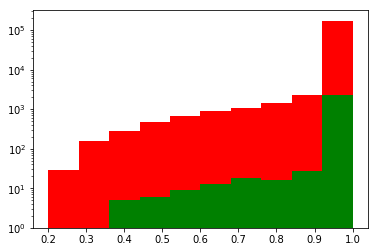

In [24]:
pred = clf.predict_proba(X_test)
cv = pd.DataFrame(pred)[df['totals.transactionRevenue'] >0][0]
# cv
non_cv = pd.DataFrame(pred)[df['totals.transactionRevenue'] == 0][0]
plt.hist([cv, non_cv], stacked=['True'], color=['g', 'r'], log=True)
print('accuracy:', clf.score(X_test, y_test))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, clf.predict(X_test)))

In [22]:
from xgboost import plot_tree
graph1 = xgb.to_graphviz(clf)
graph1.format = 'png'
graph1.render('data/tree')

'data/tree.png'

In [257]:
# ボツ
from sklearn.preprocessing import label_binarize

X_train, X_test, y_train, y_test = train_test_split(sdf, label, test_size=.2, random_state=10)

clf = LogisticRegression(penalty='l1', n_jobs=6, C=0.005)
y_score = clf.fit(X_train, y_train).decision_function(X_test)
y_test =  np.array(y_test)
y_score = np.array(y_score)

fpr, tpr, th = roc_curve(y_test, y_score)
roc_df = pd.DataFrame()
roc_df['fpr'] = fpr
roc_df['tpr'] = tpr
roc_df['th'] = th


AttributeError: 'numpy.ndarray' object has no attribute 'hist'

In [281]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, random_state=0, n_jobs=8, scoring='roc_auc').fit(sdf, label)
pred = clf.predict(sdf)

roc_auc: 0.7520113908023282


([array([0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 8.0000e+00,
         1.0000e+01, 1.4000e+01, 2.9000e+01, 9.5000e+01, 1.1356e+04]),
  array([1.0000e+00, 5.0000e+00, 4.2000e+01, 9.4000e+01, 2.0600e+02,
         4.6600e+02, 9.2100e+02, 1.7070e+03, 4.1810e+03, 8.9603e+05])],
 array([0.29338727, 0.36399731, 0.43460735, 0.50521738, 0.57582742,
        0.64643746, 0.71704749, 0.78765753, 0.85826756, 0.9288776 ,
        0.99948764]),
 <a list of 2 Lists of Patches objects>)

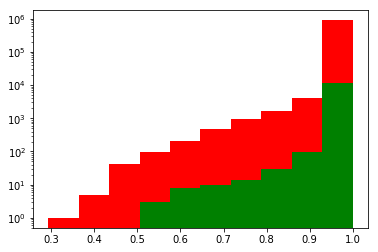

In [293]:
# pred = [1 if x else 0 for x in pred]
sc = clf.score(sdf, label)
print('roc_auc:', sc)
prob = clf.predict_proba(sdf)
cv = pd.DataFrame(prob)[df['totals.transactionRevenue'] >0][0]
# cv
non_cv = pd.DataFrame(prob)[df['totals.transactionRevenue'] == 0][0]
plt.hist([cv, non_cv], stacked=['True'], color=['g', 'r'], log=True)

In [ ]:
fpr, tpr, th = roc_curve(y_test, y_score)
roc_df = pd.DataFrame()
roc_df['fpr'] = fpr
roc_df['tpr'] = tpr
roc_df['th'] = th

In [195]:
roc_df.to_csv('data/roc.csv', index=False)
auc(fpr, tpr)

0.9536972620111257

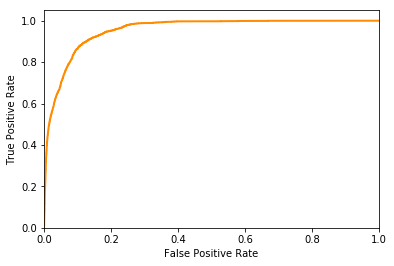

In [196]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [218]:
print(roc_df.loc[2568]) 
pred = clf.decision_function(sdf_t) # predict(sdf_t)
pred = list(map(lambda x: 1 if x > -3.6 else 0, pred))
print(sum(list(map(int, pred))) ) 
print(clf.get_params())
print(clf.coef_)
print(sdf.columns.values)
fts = pd.DataFrame()
fts['feature'] = sdf.columns.values 
fts['coef'] = clf.coef_[0]
fts['coef_abs'] = abs(clf.coef_[0])
fts = fts.sort_values(by=['coef_abs'], ascending=False)
fts

fpr    0.048908
tpr    0.686016
th    -2.781232
Name: 2568, dtype: float64
111583
{'C': 0.005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': 6, 'penalty': 'l1', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
[[-4.51576239e-01  0.00000000e+00 -6.54510593e-01  5.40134839e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.58676645e+01
   0.00000000e+00  0.00000000e+00 -7.35638411e-02 -1.34646138e-01
   7.01073840e-04  1.09220421e-02 -4.11391805e-03 -3.20780052e-01
   2.61002889e+00  0.00000000e+00 -1.42542011e-02 -1.10398500e-02
   1.83984545e-01  6.72656449e-05 -5.33160463e-04  0.00000000e+00
  -3.17097309e-08 -3.95148724e-02 -2.20945597e-02 -3.82684133e-05
   1.41788110e-04 -1.22305631e+00]]
['trafficSource.isTrueDirect' 'trafficSource.adwordsClickInfo.isVideoAd'
 'device.isMobile' 'totals.newVisits' 'visitNumber' 'visitStartTime'
 'date' 'totals.hits'

,feature,coef,coef_abs
7,totals.hits,1.586766e+01,1.586766e+01
16,totals.bounces,2.610029e+00,2.610029e+00
29,geoNetwork.continent,-1.223056e+00,1.223056e+00
2,device.isMobile,-6.545106e-01,6.545106e-01
3,totals.newVisits,5.401348e-01,5.401348e-01
0,trafficSource.isTrueDirect,-4.515762e-01,4.515762e-01
15,trafficSource.campaign,-3.207801e-01,3.207801e-01
20,trafficSource.medium,1.839845e-01,1.839845e-01
11,channelGrouping,-1.346461e-01,1.346461e-01
10,trafficSource.adwordsClickInfo.page,-7.356384e-02,7.356384e-02


In [253]:
sdf_ = sdf[df['totals.transactionRevenue'] > 0]
label_ = np.log(df[df['totals.transactionRevenue'] > 0]['totals.transactionRevenue'] + 1)

df_zero = sdf[df['totals.transactionRevenue'] == 0][:500000]
label_zero = df[df['totals.transactionRevenue'] == 0]['totals.transactionRevenue'][:500000]

sdf_ = pd.concat([sdf_, df_zero])
label_ = pd.concat([label_, label_zero])

sdf_.shape

(511515, 30)

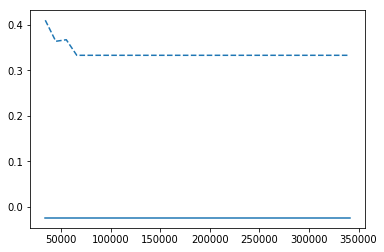

In [254]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn import linear_model

est = linear_model.LassoCV(n_alphas=20)
training_set_size, train_scores, test_scores = learning_curve(est, sdf_, label_, train_sizes=np.linspace(0.1, 1, 30))
estimator_name = est.__class__.__name__
line = plt.plot(training_set_size, train_scores.mean(axis=1), '--', label="training scores " + estimator_name)
plt.plot(training_set_size, test_scores.mean(axis=1), '-', label="test scores " + estimator_name, c=line[0].get_color())

In [229]:
from sklearn.metrics import mean_squared_error
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

[12.77865208 10.76326155 12.56003869 ... 11.84936628  7.84963127
  5.82006962]
(903653, 36) (903653, 30) 21515 21515
RMSE: 7.837070486374195


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x173ffc898>]],
      dtype=object)

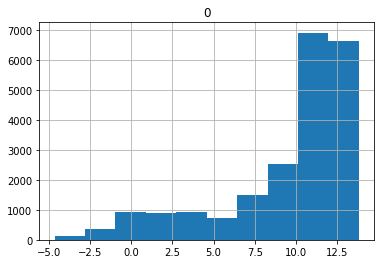

In [251]:
model = est.fit(sdf_, label_)
pre = est.predict(sdf_)
print(pre)
print(df.shape, sdf.shape, len(label_), len(pre))
print('RMSE:', RMSE(label_, pre))
pd.DataFrame(pre).hist()

(617242, 2)


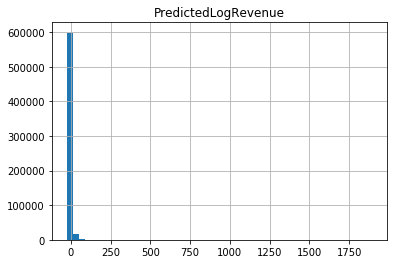

In [252]:
ans = pd.DataFrame()
ans['yo'] = pred
ans['rev'] = est.predict(sdf_t)
ans['fullVisitorId'] = df_t['fullVisitorId'].astype(str)
ans['PredictedLogRevenue'] = ans['yo'] * ans['rev']
ans = ans.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
ans.columns = ["fullVisitorId", "PredictedLogRevenue"]
# ans['PredictedLogRevenue'] = np.log(ans['PredictedLogRevenue'])
ans.to_csv('data/2class.csv', index=False)
ans.hist(bins=50)
print(ans.shape) 